<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import spacy
import re
from openpyxl.utils import get_column_letter
import os
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

BAD_SYMBOLS_RE = re.compile('<.*>|\{.*\}|[^^0-9a-z #+_]')
REPLACE_BY_SPACE_RE = re.compile('\n|[/(){}\[\]\|@,;]')
REMOVE_SPACES_RE = re.compile('  ')

df = pd.read_excel(r"C:\Users\Igor\Desktop\работа\training materials\localization_report.xlsx")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377901 entries, 0 to 377900
Data columns (total 3 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   text                     377875 non-null  object
 1   language                 377901 non-null  object
 2   has_localization_issues  377901 non-null  bool  
dtypes: bool(1), object(2)
memory usage: 6.1+ MB


In [12]:
df.describe(include='all')

,text,language,has_localization_issues
count,377875,377901,377901
unique,350420,29,2
top,好玩,english,False
freq,965,177306,373595


In [13]:
df['language'].value_counts()

english       177306
schinese       72516
russian        29134
brazilian      16725
german         14663
french         10781
tchinese        9627
koreana         9424
spanish         8799
japanese        7523
turkish         5267
polish          4737
latam           1897
italian         1858
ukrainian       1734
czech           1063
thai             884
dutch            746
portuguese       684
hungarian        579
swedish          550
finnish          361
danish           279
norwegian        257
vietnamese       123
greek            116
romanian         115
indonesian       112
bulgarian         41
Name: language, dtype: int64

Пропущенные значения:
text                        26
language                     0
has_localization_issues      0
text_length                103
dtype: int64


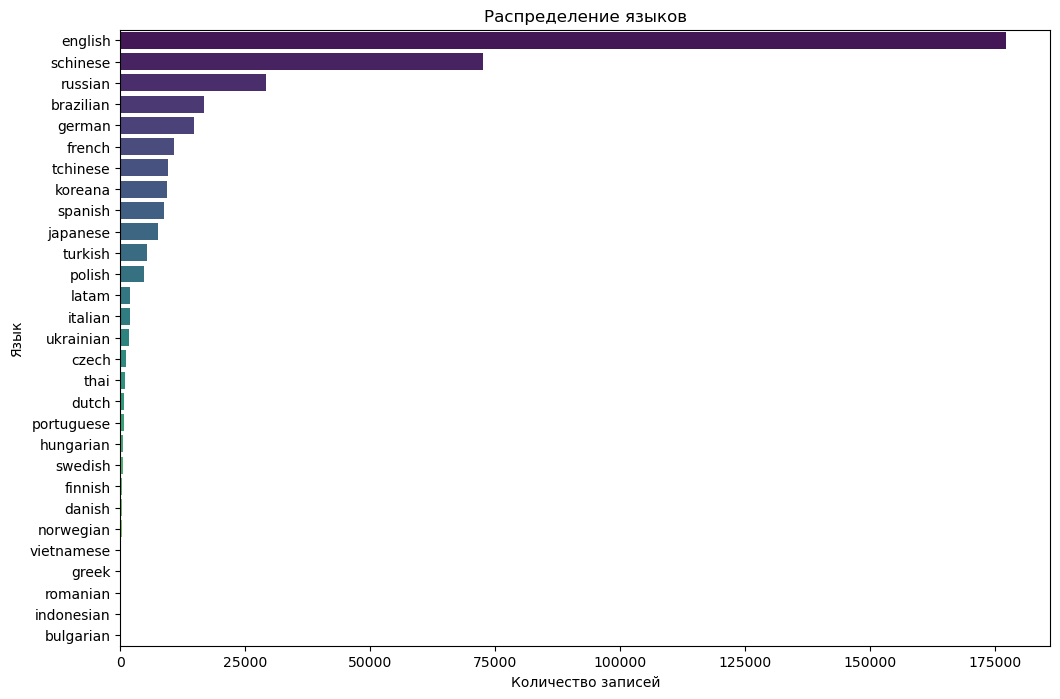

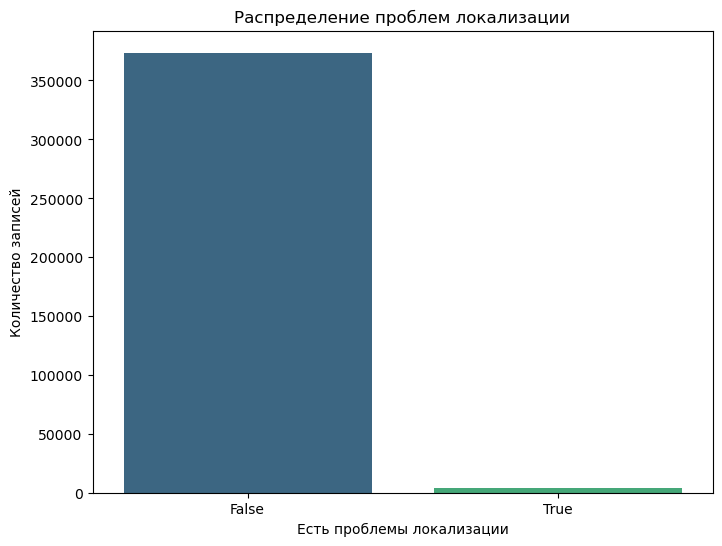

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных (если они уже загружены в df, этот шаг можно пропустить)
# df = pd.read_csv('your_data.csv')

# 1. Анализ пропущенных значений
print("Пропущенные значения:")
print(df.isnull().sum())

# 2. Распределение языков
plt.figure(figsize=(12, 8))
sns.countplot(y='language', data=df, order=df['language'].value_counts().index, palette='viridis')
plt.title('Распределение языков')
plt.xlabel('Количество записей')
plt.ylabel('Язык')
plt.show()

# 3. Распределение проблем локализации
plt.figure(figsize=(8, 6))
sns.countplot(x='has_localization_issues', data=df, palette='viridis')
plt.title('Распределение проблем локализации')
plt.xlabel('Есть проблемы локализации')
plt.ylabel('Количество записей')
plt.show()

# 4. Связь между языком и проблемами локализации
# Группируем данные по языку и проблемам локализации
language_issues = df.groupby(['language', 'has_localization_issues']).size().unstack()



Количество отзывов с проблемами локализации по языкам:
            No Issues  Has Issues
language                         
brazilian     16550.0       175.0
bulgarian        41.0         0.0
czech          1051.0        12.0
danish          279.0         0.0
dutch           745.0         1.0
english      176374.0       932.0
finnish         359.0         2.0
french        10609.0       172.0
german        14509.0       154.0
greek           116.0         0.0
hungarian       575.0         4.0
indonesian      112.0         0.0
italian        1832.0        26.0
japanese       7201.0       322.0
koreana        9073.0       351.0
latam          1863.0        34.0
norwegian       256.0         1.0
polish         4669.0        68.0
portuguese      680.0         4.0
romanian        115.0         0.0
russian       28716.0       418.0
schinese      71352.0      1164.0
spanish        8647.0       152.0
swedish         549.0         1.0
tchinese       9447.0       180.0
thai            858.0      

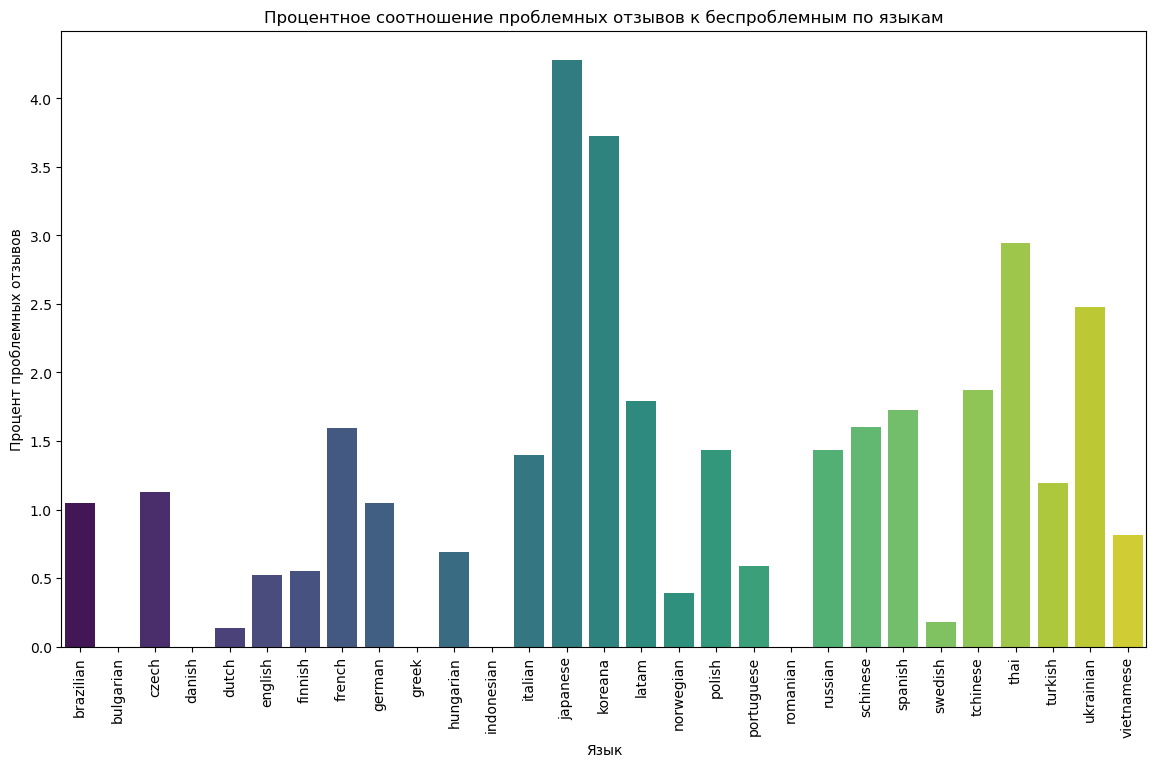

In [21]:
# 1. Количество отзывов с проблемами локализации по языкам
issues_by_language = df.groupby('language')['has_localization_issues'].value_counts().unstack().fillna(0)
issues_by_language.columns = ['No Issues', 'Has Issues']

# Вывод таблицы
print("Количество отзывов с проблемами локализации по языкам:")
print(issues_by_language)

# 2. Процентное соотношение проблемных отзывов к беспроблемным
issues_by_language['Percentage of Issues'] = (issues_by_language['Has Issues'] / 
                                              (issues_by_language['No Issues'] + issues_by_language['Has Issues'])) * 100

# Вывод таблицы
print("\nПроцентное соотношение проблемных отзывов к беспроблемным:")
print(issues_by_language[['Percentage of Issues']])

# Визуализация
plt.figure(figsize=(14, 8))
sns.barplot(x=issues_by_language.index, y=issues_by_language['Percentage of Issues'], palette='viridis')
plt.title('Процентное соотношение проблемных отзывов к беспроблемным по языкам')
plt.xlabel('Язык')
plt.ylabel('Процент проблемных отзывов')
plt.xticks(rotation=90)
plt.show()

Общее количество отзывов с проблемами локализации: 4306
Общее количество отзывов без проблем локализации: 373595
Общий процент отзывов с проблемами локализации: 1.14%


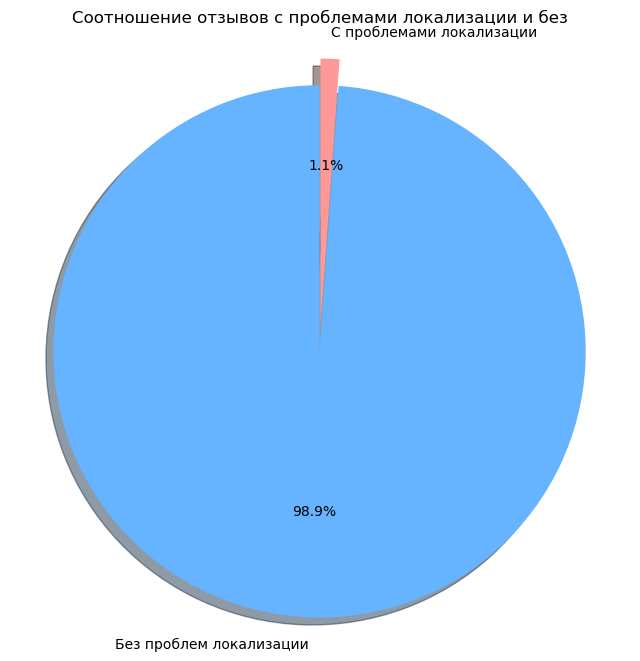

In [24]:
# 1. Общее количество отзывов с проблемами и без
total_issues = df['has_localization_issues'].value_counts()

# 2. Вычисление общего процента проблемных отзывов
total_issues_percentage = (total_issues[True] / (total_issues[True] + total_issues[False])) * 100

# Вывод результатов
print(f"Общее количество отзывов с проблемами локализации: {total_issues[True]}")
print(f"Общее количество отзывов без проблем локализации: {total_issues[False]}")
print(f"Общий процент отзывов с проблемами локализации: {total_issues_percentage:.2f}%")


# Визуализация общего процента
plt.figure(figsize=(8, 8))
labels = ['Без проблем локализации', 'С проблемами локализации']
sizes = [total_issues[False], total_issues[True]]
colors = ['#66b3ff', '#ff9999']
explode = (0.1, 0)  # Выделяем сектор "С проблемами локализации"

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Соотношение отзывов с проблемами локализации и без')
plt.axis('equal')  # Чтобы диаграмма была круглой
plt.show()

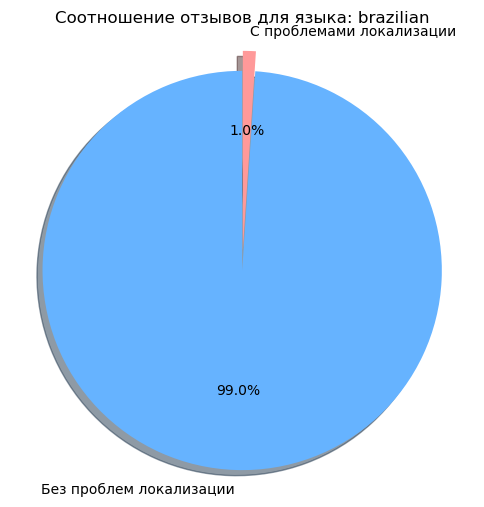

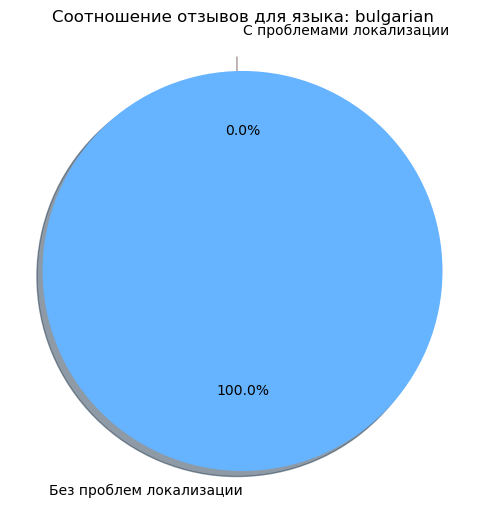

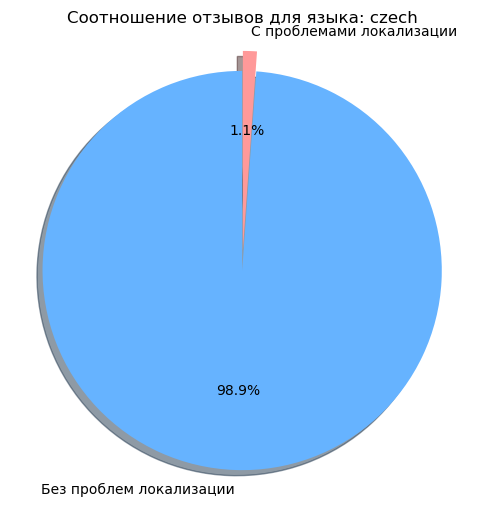

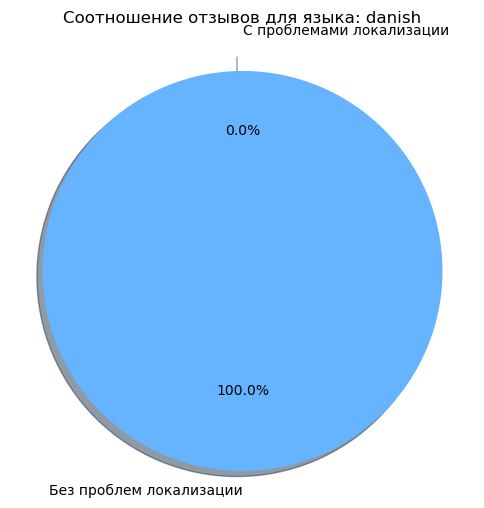

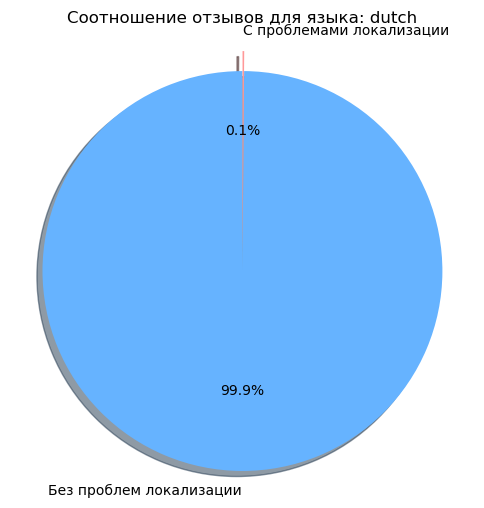

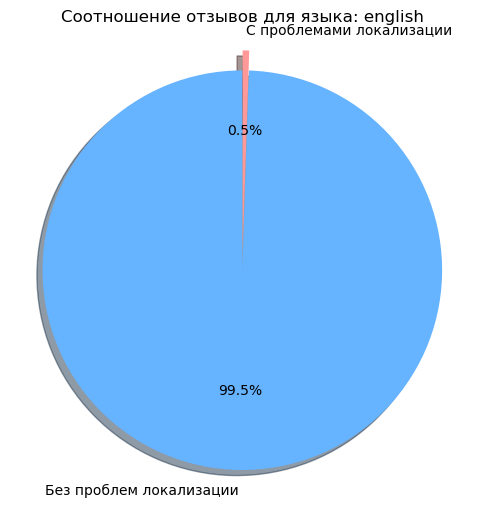

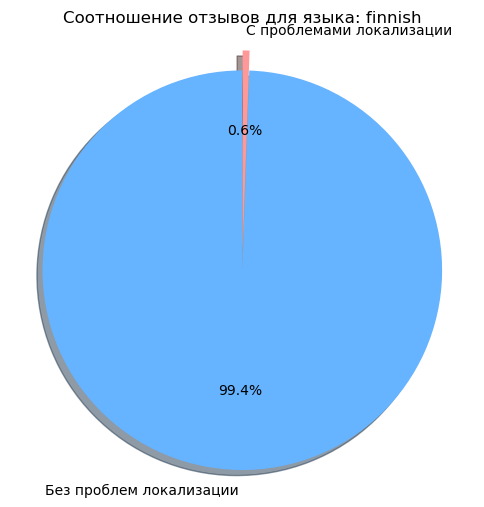

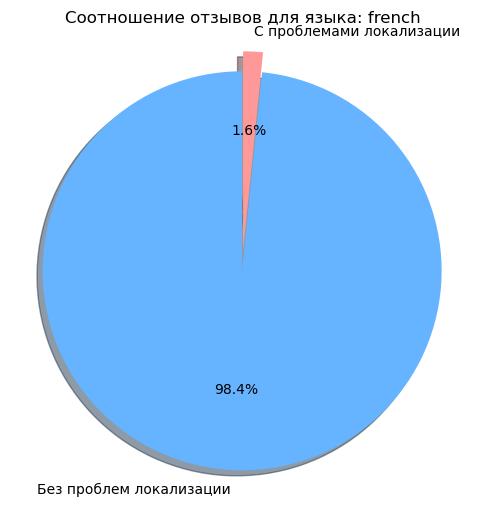

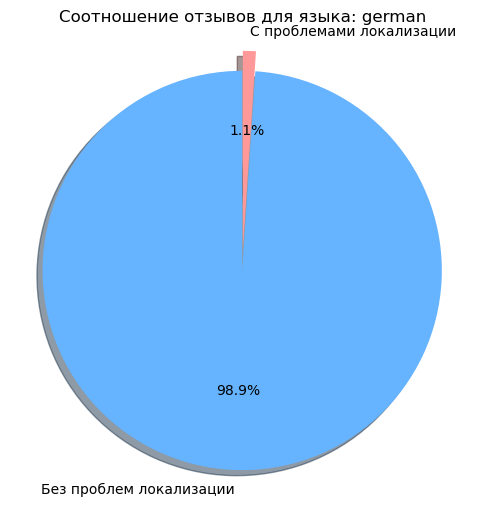

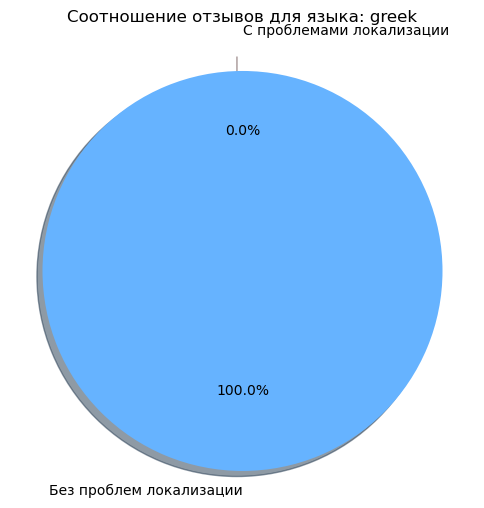

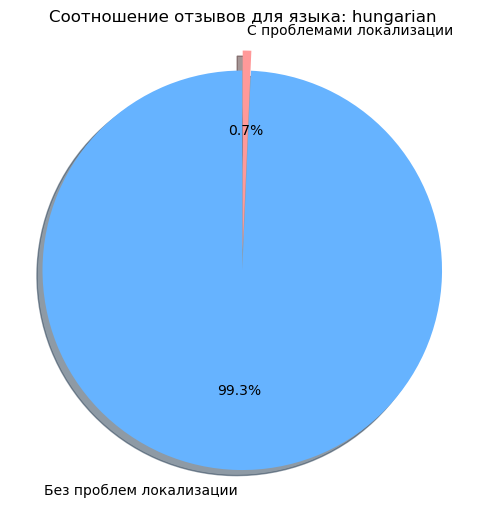

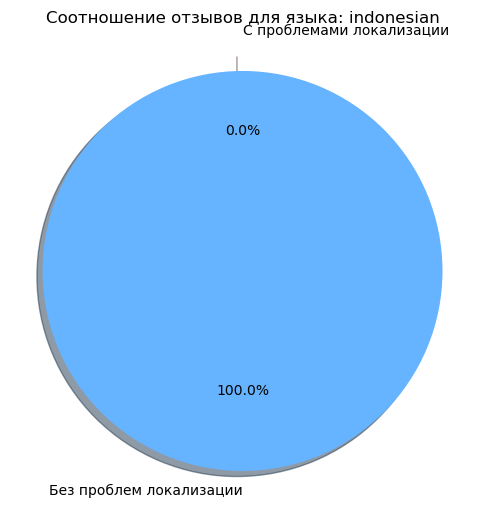

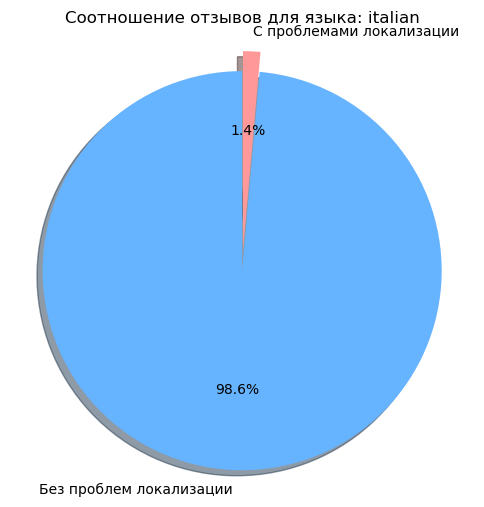

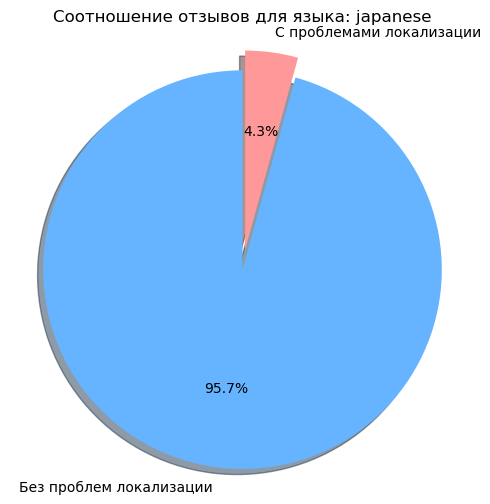

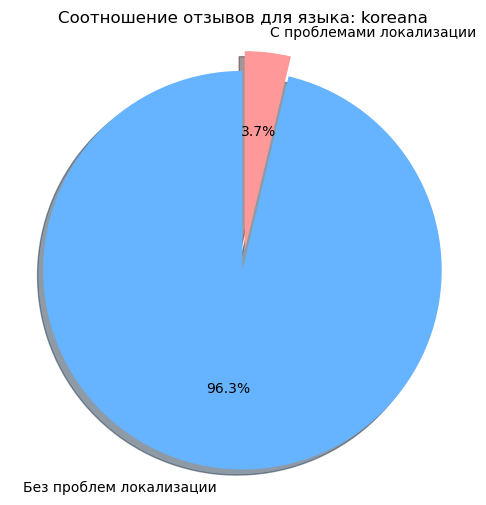

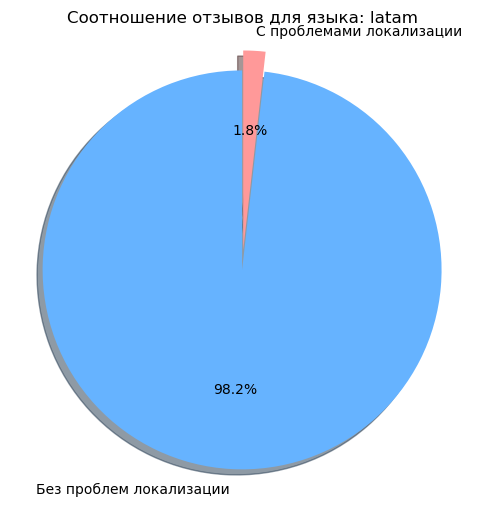

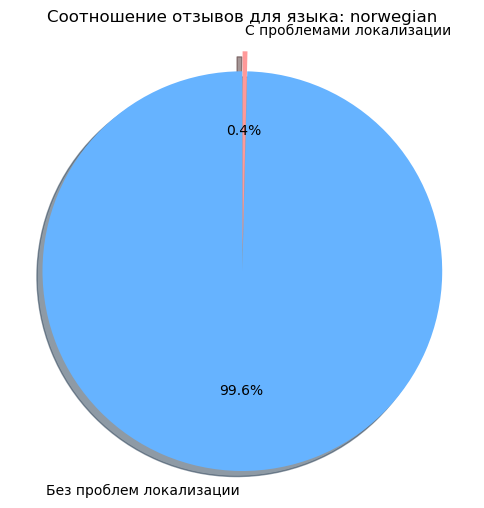

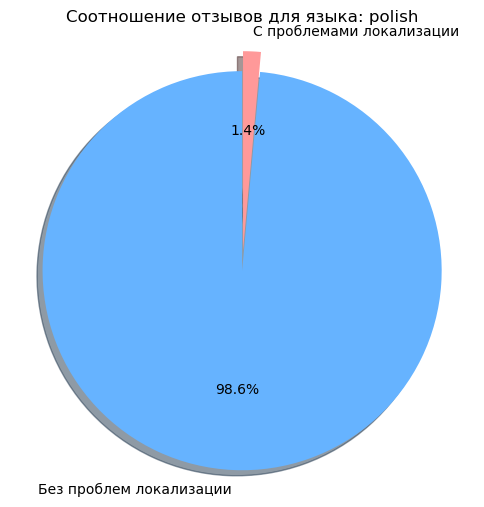

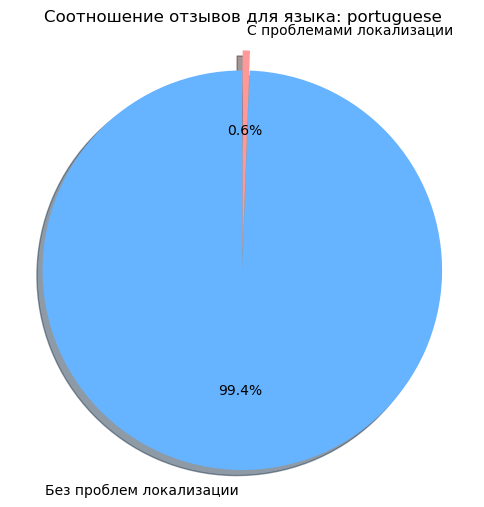

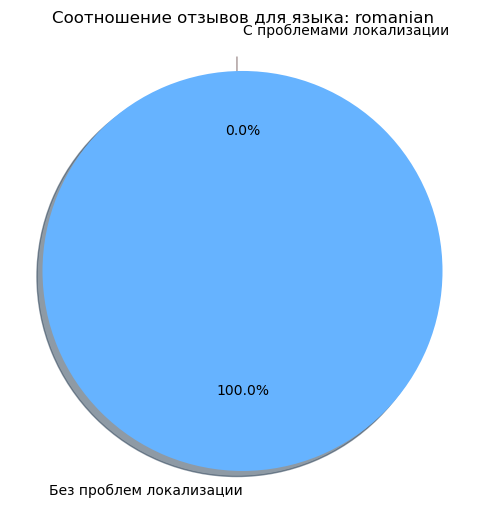

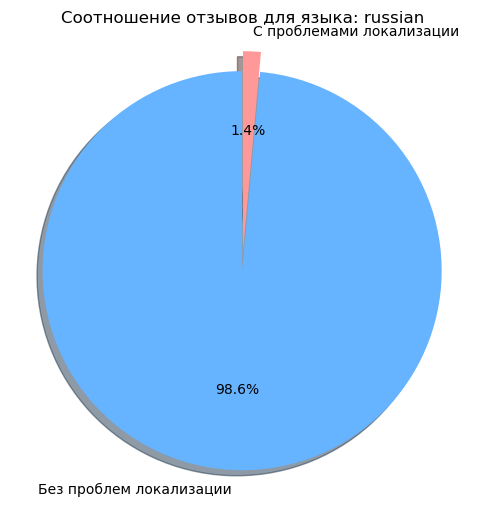

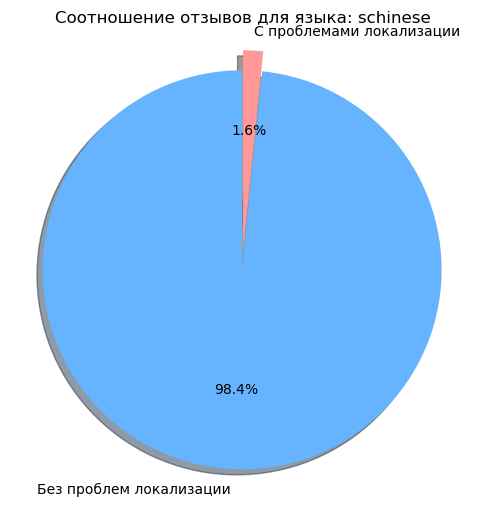

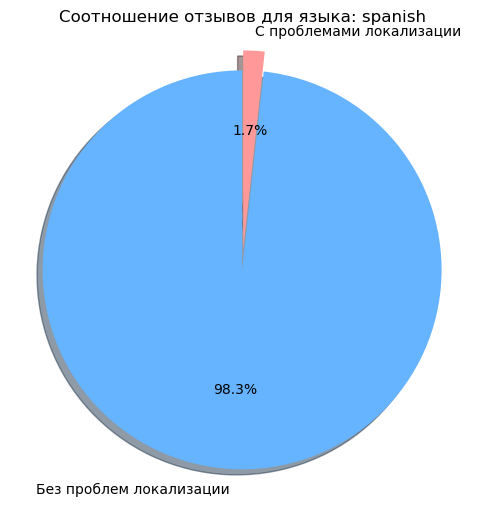

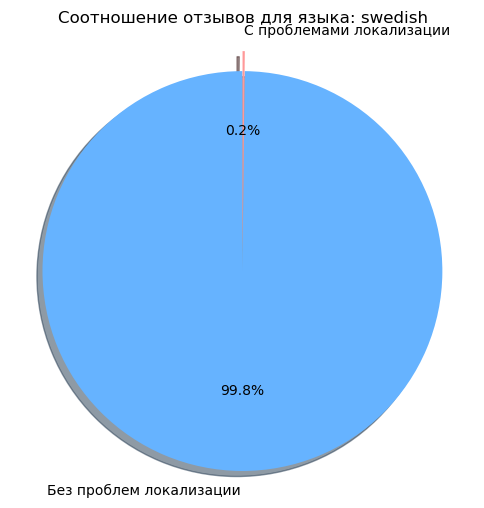

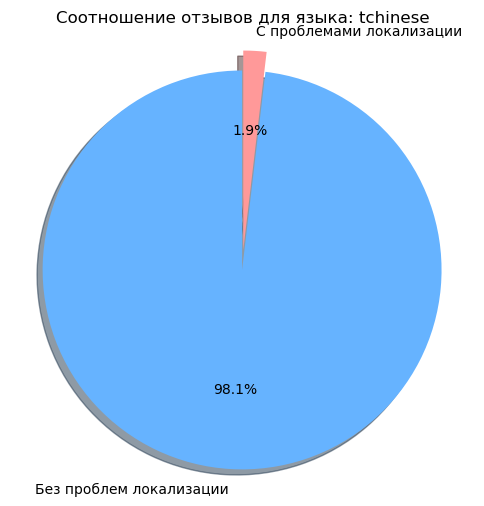

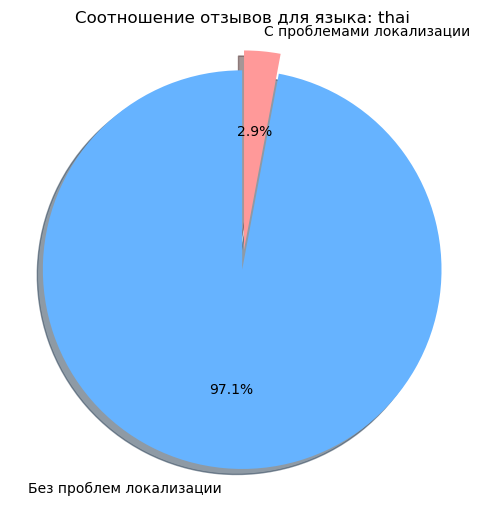

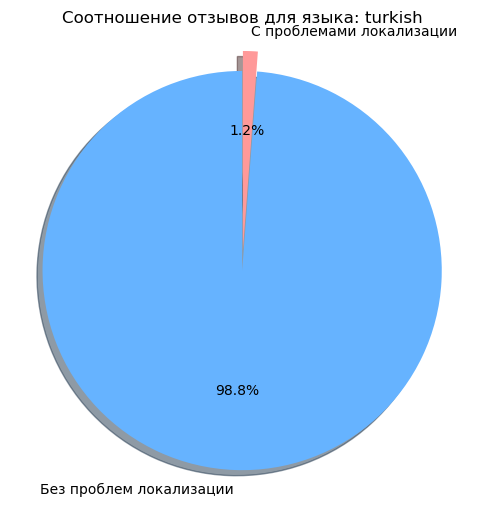

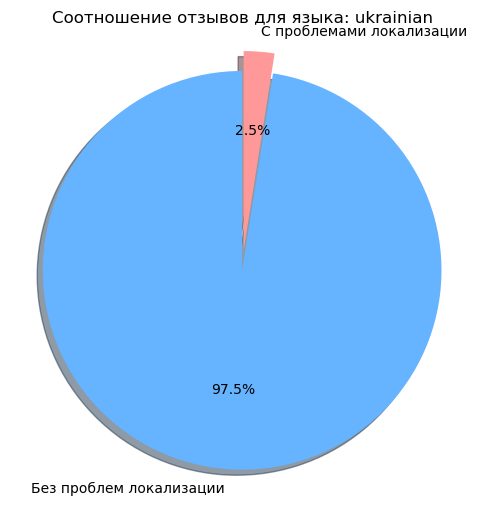

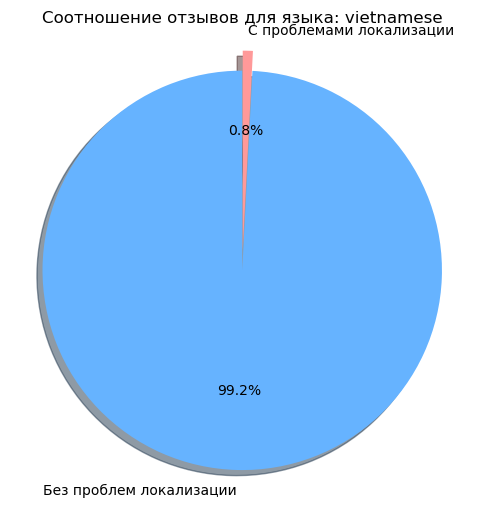

In [25]:
# Группируем данные по языкам и проблемам локализации
language_issues = df.groupby(['language', 'has_localization_issues']).size().unstack().fillna(0)
language_issues.columns = ['No Issues', 'Has Issues']

# Создаем pie chart для каждого языка
for language in language_issues.index:
    sizes = language_issues.loc[language]
    labels = ['Без проблем локализации', 'С проблемами локализации']
    colors = ['#66b3ff', '#ff9999']
    explode = (0.1, 0)  # Выделяем сектор "С проблемами локализации"

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, shadow=True)
    plt.title(f'Соотношение отзывов для языка: {language}')
    plt.axis('equal')  # Чтобы диаграмма была круглой
    plt.show()

In [32]:
!pip install mecab-python3 unidic-lite --quiet



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [47]:
import MeCab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Инициализация MeCab для японского языка
mecab = MeCab.Tagger()

# Функция предобработки текста для японского языка
def text_prepare_japanese(text):
    if not text or isinstance(text, str) is False:
        return ''
    
    try:
        # Токенизация и лемматизация с использованием MeCab
        parsed = mecab.parse(text)
        tokens = [line.split('\t')[0] for line in parsed.split('\n') if line]
        # Удаление стоп-слов
        stopwords = ["の", "に", "は", "を", "た", "が", "で", "て", "と", "し", "れ", "さ", "いる", "も", "する", "から", "な", "こと", "として", "い", "や", "など"]
        tokens = [token for token in tokens if token not in stopwords]
        return " ".join(tokens)
    
    except Exception as e:
        print(f"Error processing text: {text}")
        print(e)
        return ''

# Фильтрация данных для японского языка
japanese_data = df[df['language'] == 'japanese']

# Балансировка данных
issues = japanese_data[japanese_data['has_localization_issues'] == True]
no_issues = japanese_data[japanese_data['has_localization_issues'] == False]

min_samples = min(len(issues), len(no_issues))
issues = issues.sample(min_samples, random_state=42)
no_issues = no_issues.sample(min_samples, random_state=42)

balanced_data = pd.concat([issues, no_issues])

# Разделение на признаки и целевую переменную
X_train_raw = balanced_data['text']
y_train = balanced_data['has_localization_issues']

# Применение предобработки текста
X_train_processed = [text_prepare_japanese(x) for x in X_train_raw]

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_train_processed, y_train, test_size=0.2, random_state=42)

# Используем TF-IDF для векторизации текста
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_embedded_tfidf = tfidf.fit_transform(X_train)
X_test_embedded_tfidf = tfidf.transform(X_test)

# Определяем модель логистической регрессии
logreg = LogisticRegression()

# Настройка гиперпараметров
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Используем GridSearchCV
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_embedded_tfidf, y_train)

# Лучшие параметры
print("Best parameters:", grid_search.best_params_)

# Обученная модель
best_logreg = grid_search.best_estimator_

# Прогнозирование
y_logreg_optimized = best_logreg.predict(X_test_embedded_tfidf)

# Оценка качества модели
print("Optimized Accuracy:", accuracy_score(y_test, y_logreg_optimized))
print("Optimized Precision:", precision_score(y_test, y_logreg_optimized))
print("Optimized Recall:", recall_score(y_test, y_logreg_optimized))
print("Optimized F-score:", f1_score(y_test, y_logreg_optimized))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'C': 10, 'solver': 'saga'}
Optimized Accuracy: 0.8527131782945736
Optimized Precision: 0.9230769230769231
Optimized Recall: 0.8108108108108109
Optimized F-score: 0.8633093525179856


C:\Users\Igor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [49]:
pd.set_option('display.max_colwidth', None)  # Показывает полный текст в столбцах
# Обработка реальных данных
X_real_data = df[df['language'] == 'japanese']['text']
X_real_data_processed = [text_prepare_japanese(x) for x in X_real_data]
X_real_data_embedded = tfidf.transform(X_real_data_processed)

# Прогнозирование
y_real_data_logreg = best_logreg.predict(X_real_data_embedded)

# Добавляем предсказания
real_data_predictions = df[df['language'] == 'japanese'].copy()
real_data_predictions['Predicted has_localization_issues'] = y_real_data_logreg

# Вывод нескольких примеров
print(real_data_predictions[['text', 'Predicted has_localization_issues']].head())

                                                                                                                                                                                                                                                                                                                                                                                                                                                                        text  \
8   この手のパズルは苦手だけど、チュートリアルが終わったぐらいでAUTOが解禁されるので自分が操作するより優秀。\nよく考えずにゴールドをガチャに使ったら、強化でもゴールドを使うことを後から知り素材は合っても強化費用が足りなくなった。\nダンジョンやタワーなどのコンテンツを進めているとゴールドは貯まる。\nキャラの数や装備など一覧を見るだけでも大量にある。\n日本語はなんでその言葉を選んだんだ？みたいなのはあるけど意味はわかる。\n\n自分の場合バトルはAUTOで見ているだけなので高速化やスキップがほしくなった。\nゲームを進めていくと報酬を受け取るのに時間経過が必要だったり、ダンジョン、クエストなど時間待ちが目立ってくる。\n課金して時間を短縮するか、まったりと時間をかけて遊ぶかのどちらか。\n\nコレクションしたり強化していくのは楽しいので暇つぶしにはなる。\n買い切りで安価、そして時間制限がないならコンプリートするまでやっていただろう。\nゲームには楽しいとこはあるが自分にはお金も時間も足りない。   
9                                                                       

гугл перевод отзывов
8 I'm not good at this kind of puzzle, but AUTO is unlocked after the tutorial, so it's better than operating it yourself. \nI used gold on gacha without thinking, and later I found out that gold is also used for strengthening, so even though I had the right materials, I didn't have enough for strengthening. \nYou can save up gold by progressing through content such as dungeons and towers. \nThere are a lot of them just by looking at the list of the number of characters and equipment. \nI'm not sure why they chose that word in Japanese, but I understand what they mean. \n\nIn my case, I only watch battles on AUTO, so I wanted to speed them up or skip them. \nAs you progress through the game, it takes time to receive rewards, and dungeons, quests, and other things become more noticeable when you have to wait for a while. \nYou can either pay to shorten the time, or take your time to play. \n\nCollecting and strengthening is fun, so it's a good way to kill time. \nIf it was a one-time purchase, cheap, and there was no time limit, I would have played until I completed it. \nThere are fun aspects to the game, but I don't have enough money or time.
9 Review after defeating the boss of the normal dungeon (the Snow Queen)\n\nIt's tough without paying, but the weak yen is tough if you pay\nThe game is all about collecting characters\n\nThe basic way to earn money is to use the tower, but pink crystals are valuable\nTry not to use them to open treasure chests by mistake\nUse pink crystals for gacha\nI unlocked one slot on the tower (paid) so even one will make things easier\n\nThe Japanese translation is questionable so it's hard to understand what the quest is\nI like the characters so I'll play a bit more. \n
17 PC version of a smartphone game. \nWestern RPGs (in the original sense) have become much less common recently. \nIt has some obvious flaws so it's not for everyone, but the game balance is good and it's very interesting. I would recommend it to RPG professionals who know the taste. \n\n〇 It has the original fun of RPGs, which is to "feel while playing". \n〇 It works well with mouse controls, and the addition of keyboard shortcuts makes it easy to use. \nX Machine translation so poor that the meaning of the conversation is not clear. \n\nIt seems that the loading time was noticeable in the smartphone game version due to memory capacity (depending on the model). The PC version has no such concerns and is very light, which I think is a positive reason to choose the PC version. \nThe graphics are the same as the screenshots, and frankly they are cheap, but they have a certain charm so you can enjoy it without feeling out of place. \nIf you would prefer to play on your smartphone, there are apps with the same name for both Android and iPhone, so you can choose those.
21 The translation is sloppy and the graphics are by no means good\nBut I like this game.
29 It maintains the old MMO feel while improving the inconvenience of the previous game, so I'm very satisfied. \n・Reduced re-rolling\n・Expanded skill tree width through party system\n・Reduced lack of money\n・Reduced fast travel\n・Dual wielding, shield man, healer, and brainless (interference) party are consistently recommended. \n\nHowever, the translation is quite sloppy. The story is easy to follow, but some quests are extremely difficult due to no hints or poor translation.

Predicted has_localization_issues
8 True
9 True
17 True
21 True
29 True

Выводы:
1% отзывов касается локализации
=> 99% времени видеокарта работает вхолостую

можно игнорить такие языки, как 

hungarian        579
finnish          361
greek            116
romanian         115
indonesian       112
bulgarian         41

т.к. мы не работаем с этими языками

Модель машинного обучения для японского языка верно определила 85% отзывов с проблемой на локу


Топ-3 проблемных отзыва по языкам
1. Japanese 
2. Chinese
3. Korean 

Предлагаю создать проприетарные мл-модельки для этих языков и парсить без аренды оборудования